# ZERO: Zimbabwe Energy Resilience Optimization - Prototype Development

### Introduction:

    Zimbabwe faces a persistent challenge of power outages, impacting the economy, essential services, and the lives of its citizens. This notebook documents the development of a prototype system designed to predict weather-related power outages using machine learning. The prototype utilizes historical outage data from the EAGLE-I dataset (United States) and weather event data to train and evaluate predictive models. This initial stage focuses on exploring data patterns, feature engineering, and model selection, with the goal of developing a robust system that can ultimately be deployed using real-time data from Zimbabwe's energy grid.

In [1]:
# 1. Load important libraries for this project
import polars as pl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Load Data

In [2]:
def load_data(file_path):
    """Loads a CSV file into a Polars DataFrame."""
    return pl.read_csv(file_path)

df_outages = load_data("datasets/eaglei_outages_2016.csv")  
df_weather = load_data("datasets/WeatherEvents_Jan2016-Dec2022.csv") 
data = pl.read_csv("datasets/data.csv")

In [3]:
df_outages.head()

fips_code,county,state,customers_out,run_start_time
i64,str,str,i64,str
2122,"""Kenai Peninsula""","""Alaska""",657,"""2016-01-01 00:00:00"""
5003,"""Ashley""","""Arkansas""",7,"""2016-01-01 00:00:00"""
5029,"""Conway""","""Arkansas""",2,"""2016-01-01 00:00:00"""
5069,"""Jefferson""","""Arkansas""",41,"""2016-01-01 00:00:00"""
5081,"""Little River""","""Arkansas""",61,"""2016-01-01 00:00:00"""


In [3]:
df_weather.head()

EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
str,str,str,str,str,f64,str,str,f64,f64,str,str,str,i64
"""W-1""","""Snow""","""Light""","""2016-01-06 23:14:00""","""2016-01-07 00:34:00""",0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-2""","""Snow""","""Light""","""2016-01-07 04:14:00""","""2016-01-07 04:54:00""",0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-3""","""Snow""","""Light""","""2016-01-07 05:54:00""","""2016-01-07 15:34:00""",0.03,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-4""","""Snow""","""Light""","""2016-01-08 05:34:00""","""2016-01-08 05:54:00""",0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-5""","""Snow""","""Light""","""2016-01-08 13:54:00""","""2016-01-08 15:54:00""",0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149


# 2. Data Cleaning and Preprocessing

In [5]:
def clean_data(df):
    """Cleans and prepares the data for model training."""
    # Convert date columns to datetime format
    if "run_start_time" in df.columns: 
        df = df.with_columns(pl.col("run_start_time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))
    if "StartTime(UTC)" in df.columns: 
        df = df.with_columns(pl.col("StartTime(UTC)").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))
    if "EndTime(UTC)" in df.columns:
        df = df.with_columns(pl.col("EndTime(UTC)").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))

    # Remove irrelevant outage causes (example)
    if "cause" in df.columns:
        df = df.filter(pl.col("cause") != "Planned Outage")  # Filter out planned outages

    # Handle missing values (example - you may need more sophisticated strategies)
    if "Precipitation(in)" in df.columns:
        df = df.with_columns(pl.col("Precipitation(in)").fill_null(pl.col("Precipitation(in)").mean()))
    if "severity_encoded" in df.columns:
        df = df.with_columns(pl.col("severity_encoded").fill_null(0)) # Fill missing severity with 0

    return df

df_outages = clean_data(df_outages)
df_weather = clean_data(df_weather)

In [6]:
df_outages.sample(10)

fips_code,county,state,customers_out,run_start_time
i64,str,str,i64,datetime[μs]
31161,"""Sheridan""","""Nebraska""",10,2016-12-18 02:15:00
17019,"""Champaign""","""Illinois""",2,2016-08-30 20:30:00
36121,"""Wyoming""","""New York""",6,2016-06-04 04:00:00
51059,"""Fairfax""","""Virginia""",21,2016-10-01 04:30:00
13137,"""Habersham""","""Georgia""",1,2016-03-14 15:00:00
53029,"""Island""","""Washington""",1,2016-03-31 21:30:00
26147,"""St. Clair""","""Michigan""",65,2016-02-22 04:00:00
36121,"""Wyoming""","""New York""",21,2016-06-25 10:45:00
12105,"""Polk""","""Florida""",3,2016-02-07 21:00:00


In [7]:
df_weather.sample(3)

EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
str,str,str,datetime[μs],datetime[μs],f64,str,str,f64,f64,str,str,str,i64
"""W-2314109""","""Fog""","""Severe""",2017-01-18 07:32:00,2017-01-18 07:56:00,0.0,"""US/Eastern""","""KABY""",31.5365,-84.1957,"""Albany""","""Dougherty""","""GA""",31721
"""W-4823698""","""Rain""","""Light""",2017-12-07 03:56:00,2017-12-07 04:33:00,0.0,"""US/Central""","""KLRD""",27.5437,-99.4616,"""Laredo""","""Webb""","""TX""",78041
"""W-8485138""","""Fog""","""Severe""",2017-10-06 14:53:00,2017-10-06 15:24:00,0.0,"""US/Mountain""","""KVEL""",40.443,-109.5127,"""Vernal""","""Uintah""","""UT""",84078


In [ ]:
df_weather = df_weather.filter(pl.col("year") == 2016)

In [8]:
df_weather = df_weather.filter(pl.col("Severity").is_in(["Severe", "Light", "Moderate", "Heavy"]))

In [9]:
df_weather.head()

EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
str,str,str,datetime[μs],datetime[μs],f64,str,str,f64,f64,str,str,str,i64
"""W-1""","""Snow""","""Light""",2016-01-06 23:14:00,2016-01-07 00:34:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-2""","""Snow""","""Light""",2016-01-07 04:14:00,2016-01-07 04:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-3""","""Snow""","""Light""",2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-4""","""Snow""","""Light""",2016-01-08 05:34:00,2016-01-08 05:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149
"""W-5""","""Snow""","""Light""",2016-01-08 13:54:00,2016-01-08 15:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149


# 3. Feature Engineering

In [10]:
# Add "power_outage" column
df_outages = df_outages.with_columns(
    (pl.col("customers_out") > 10).cast(pl.Int8).alias("power_outage")
)  # Define power outages based on customer count

In [11]:
# Extract date components from run_start_time in df_outages
df_outages = df_outages.with_columns(
    [
        pl.col("run_start_time").dt.year().alias("year"),
        pl.col("run_start_time").dt.month().alias("month"),
        pl.col("run_start_time").dt.day().alias("day"),
        pl.col("run_start_time").dt.hour().alias("hour"),
        pl.col("run_start_time").dt.weekday().alias("weekday"),  # Create day-of-week feature
    ]
)

In [12]:
# Extract date components from StartTime(UTC) in df_weather
df_weather = df_weather.with_columns(
    [
        pl.col("StartTime(UTC)").dt.year().alias("year"),
        pl.col("StartTime(UTC)").dt.month().alias("month"),
        pl.col("StartTime(UTC)").dt.day().alias("day"),
        pl.col("StartTime(UTC)").dt.hour().alias("hour"),
        pl.col("StartTime(UTC)").dt.weekday().alias("weekday"),
    ]
)

In [13]:
# One-hot encoding for weather types
weather_types = ["Rain", "Cold", "Snow", "Fog"]
for weather_type in weather_types:
    df_weather = df_weather.with_columns(
        (pl.col("Type") == weather_type).cast(pl.Int8).alias(weather_type.lower())
    )  # One-hot encoding for weather types

In [14]:
# Calculate duration of weather events
df_weather = df_weather.with_columns(
    (pl.col("EndTime(UTC)") - pl.col("StartTime(UTC)")).dt.total_hours().alias("duration_hours")
)  # Duration in hours

In [15]:
# Assign numerical values to severity levels, filter out others
severity_mapping = {"Light": 1, "Moderate": 2, "Heavy": 3, "Severe": 4}
df_weather = df_weather.with_columns(
    pl.col("Severity").replace(severity_mapping).alias("severity_encoded")
).with_columns(
    pl.col("severity_encoded").cast(pl.Int8)
).filter(
    pl.col("severity_encoded").is_in([1, 2, 3, 4])
).select(
    ["*"]
)

In [16]:
df_weather.head()

EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,year,month,day,hour,weekday,rain,cold,snow,fog,duration_hours,severity_encoded
str,str,str,datetime[μs],datetime[μs],f64,str,str,f64,f64,str,str,str,i64,i32,i8,i8,i8,i8,i8,i8,i8,i8,i64,i8
"""W-1""","""Snow""","""Light""",2016-01-06 23:14:00,2016-01-07 00:34:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149,2016,1,6,23,3,0,0,1,0,1,1
"""W-2""","""Snow""","""Light""",2016-01-07 04:14:00,2016-01-07 04:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149,2016,1,7,4,4,0,0,1,0,0,1
"""W-3""","""Snow""","""Light""",2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149,2016,1,7,5,4,0,0,1,0,9,1
"""W-4""","""Snow""","""Light""",2016-01-08 05:34:00,2016-01-08 05:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149,2016,1,8,5,5,0,0,1,0,0,1
"""W-5""","""Snow""","""Light""",2016-01-08 13:54:00,2016-01-08 15:54:00,0.0,"""US/Mountain""","""K04V""",38.0972,-106.1689,"""Saguache""","""Saguache""","""CO""",81149,2016,1,8,13,5,0,0,1,0,2,1


In [17]:
df_outages.head()

fips_code,county,state,customers_out,run_start_time,power_outage,year,month,day,hour,weekday
i64,str,str,i64,datetime[μs],i8,i32,i8,i8,i8,i8
2122,"""Kenai Peninsula""","""Alaska""",657,2016-01-01 00:00:00,1,2016,1,1,0,5
5003,"""Ashley""","""Arkansas""",7,2016-01-01 00:00:00,0,2016,1,1,0,5
5029,"""Conway""","""Arkansas""",2,2016-01-01 00:00:00,0,2016,1,1,0,5
5069,"""Jefferson""","""Arkansas""",41,2016-01-01 00:00:00,1,2016,1,1,0,5
5081,"""Little River""","""Arkansas""",61,2016-01-01 00:00:00,1,2016,1,1,0,5


In [18]:
# Drop unnecessary columns from df_weather
df_weather = df_weather.drop(
    [
        "Type",
        "EventId",
        "StartTime(UTC)",
        "EndTime(UTC)",
        "AirportCode",
        "LocationLat",
        "LocationLng",
        "ZipCode",
        "TimeZone",
        "City",
    ]
)

In [19]:
# Lagged features for precipitation and rain
for i in range(1, 3):
    df_weather = df_weather.with_columns(
        [
            pl.col("Precipitation(in)").shift(i).alias(f"Precipitation_lag_{i}"),
            pl.col("rain").shift(i).alias(f"rain_lag_{i}"),
        ]
    ) 

In [20]:
# Combined features
df_weather = df_weather.with_columns(
    [
        (pl.col("rain") * pl.col("cold")).alias("rain_and_cold"),
        (pl.col("snow") * pl.col("fog")).alias("snow_and_fog"), # Combined weather features
    ]
)

In [22]:
df_outages=df_outages.rename({'state':'State'})
df_outages= df_outages.rename({'county':'County'})

In [23]:
df_outages = df_outages.join(data, on="State", how="left",coalesce=True)

In [24]:
df_weather = df_weather.rename({'State':'State_code'})

# 4. Merge DataFrames

In [26]:
merged_df = df_outages.join(
    df_weather,
    on=["State_code", "County", "year", "month", "day", "hour", "weekday"],
    how="left", coalesce=True
)  # Merge based on common columns

# 5. Handle Null Values and Inconsistent Data

In [27]:
merged_df = merged_df.drop_nulls()

# 6. Feature Selection

In [29]:
features = [
    "Precipitation(in)",
    "rain",
    "cold",
    "snow",
    "fog",
    "severity_encoded",
    "Precipitation_lag_1",
    "Precipitation_lag_2",
    "rain_lag_1",
    "rain_lag_2",
    "rain_and_cold",
    "snow_and_fog",
]
X = merged_df.select(features)
y = merged_df["power_outage"]

# 7. Feature Scaling

In [30]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.to_numpy())  # Scale features (if needed)

# 8. Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.to_numpy(), test_size=0.2, random_state=42)  # Split data into training and testing sets

# 9. Model Training and Evaluation

In [32]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    """Trains and evaluates the specified model."""
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()
    
    return model, y_pred

# 10. Model Selection (Logistic Regression)

In [34]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(max_iter=500)

Accuracy: 0.5756
Precision: 0.5865
Recall: 0.8964
F1-score: 0.7091
AUC: 0.5172


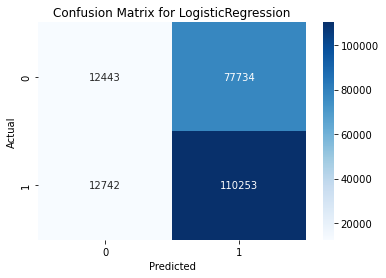

In [35]:
# Train and evaluate the model
logreg_model, y_pred_logreg = train_and_evaluate(logreg_model, X_train, y_train, X_test, y_test)

# 11. Model Selection (Decision Tree)

In [36]:
dt_model = DecisionTreeClassifier(random_state=42)

Accuracy: 0.6539
Precision: 0.6631
Recall: 0.8131
F1-score: 0.7305
AUC: 0.6249


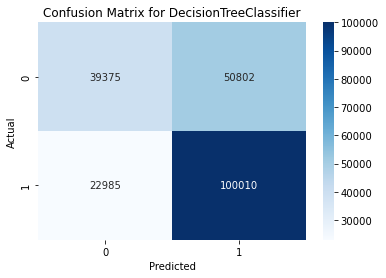

In [37]:
# Train and evaluate the model
dt_model, y_pred_dt = train_and_evaluate(dt_model, X_train, y_train, X_test, y_test)

# 12. Model Selection (Random Forest)

In [38]:

rf_model = RandomForestClassifier(random_state=42)

Accuracy: 0.6551
Precision: 0.6611
Recall: 0.8254
F1-score: 0.7342
AUC: 0.6241


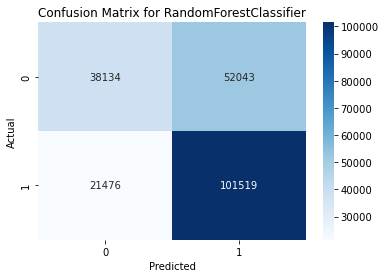

In [39]:
# Train and evaluate the model
rf_model, y_pred_rf = train_and_evaluate(rf_model, X_train, y_train, X_test, y_test)

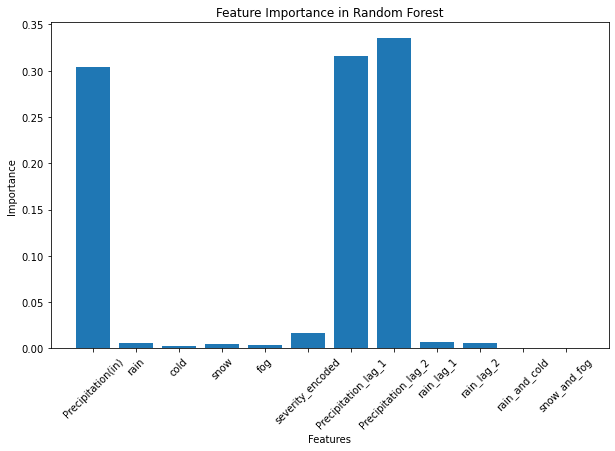

In [40]:
if isinstance(rf_model, RandomForestClassifier):
    importances = rf_model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.bar(features, importances)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance in Random Forest')
    plt.xticks(rotation=45)
    plt.show()